In [14]:
#Import
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os

#Pytoch
import torch
from torchvision import datasets,models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from timeit import default_timer as timer

# Visualizationsos
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt



# Load Data

In [15]:
# Input images normalized in the same way and the image H and W are expected to be at least 224
#https://pytorch.org/vision/stable/transforms.html
tforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_tfroms = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ColorJitter(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])])

In [16]:
# Import train , test and validation data
train_damage = datasets.ImageFolder(r'C:\Users\f_ati\Documents\Master2\DeepLearning\projet\Post-hurricane\train_another',transform=train_tfroms)
test_damage = datasets.ImageFolder(r'C:\Users\f_ati\Documents\Master2\DeepLearning\projet\Post-hurricane\test_another',transform=train_tfroms)
data_val = datasets.ImageFolder(r'C:\Users\f_ati\Documents\Master2\DeepLearning\projet\Post-hurricane\validation_another',transform=tforms)


In [17]:
## Import train , test and validation data
train_loader = DataLoader(train_damage, batch_size = 50,  shuffle = True)
x_train, y_train = iter(train_loader).next()

val_loader = DataLoader(data_val,batch_size = 50, shuffle = True)
x_val, y_val = iter(val_loader).next()

test_loader = DataLoader(test_damage,batch_size = 40, shuffle = False)
x_test, y_test = iter(test_loader).next()


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# pre-trained model
def get_pretrained_model(model_name):
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features
        n_classes = 2

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        n_classes = 2
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes))

    
    MODEL = model.to(device)

    return MODEL

# ResNet 50

In [19]:
# VGG 16
model_vgg = get_pretrained_model('vgg16')
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.Adam(model_vgg.parameters(), lr=0.00002)

# ResNet 50
model_resnet50 = get_pretrained_model('resnet50')
criterion_resnet50 = nn.CrossEntropyLoss() #nn.BCELoss()
optimizer_resnet50 = torch.optim.Adam(model_resnet50.parameters(), lr=0.001)



In [20]:
def acc_vgg(x, y, return_labels=False):
    with torch.no_grad():
        logits = model_vgg(x)
        pred_labels = np.argmax(logits.cpu().numpy(), axis=1)
    if return_labels:
        return pred_labels
    else:
        return 100*accuracy_score(y.cpu().numpy(), pred_labels)

def acc_resnet50(x, y, return_labels=False):
    with torch.no_grad():
        logits = model_resnet50(x)
        pred_labels = np.argmax(logits.cpu().numpy(), axis=1)
    if return_labels:
        return pred_labels
    else:
        return 100*accuracy_score(y.cpu().numpy(), pred_labels)



In [21]:
def fit(model, criterion, optimizer, acc, xtrain, ytrain, xval, yval, save_file_name, n_epochs, BATCH_SIZE):

    history1 = []

    # Number of epochs already trained 
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')


    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        val_loss = 0.0

        train_acc = 0
        val_acc = 0

        # Set to training
        model.train()

        #Training loop
        for batch in range(len(xtrain)//BATCH_SIZE):
            idx = slice(batch * BATCH_SIZE, (batch+1)*BATCH_SIZE)

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs
            output = model(xtrain[idx])
            # Loss and BP of gradients
            loss = criterion(output, ytrain[idx])
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Track train loss
            train_loss += loss.item()
            train_acc = acc(xtrain, ytrain)

        # After training loops ends, start validation
        # set to evaluation mode
        model.eval()
        # Don't need to keep track of gradients
        with torch.no_grad():
            # Evaluation loop
            # F.P.
            y_val_pred = model(xval)
            # Validation loss
            loss = criterion(y_val_pred, yval)
            val_loss = loss.item()
            val_acc = acc(xval, yval)

            history1.append([train_loss / BATCH_SIZE, val_loss, train_acc, val_acc])
            torch.save(model.state_dict(), save_file_name)
            torch.cuda.empty_cache()

            # Print training and validation results
        print("Epoch {} | Train Loss: {:.5f} | Train Acc: {:.2f} | Valid Loss: {:.5f} | Valid Acc: {:.2f} |".format(
            epoch, train_loss / BATCH_SIZE, acc(xtrain, ytrain), val_loss, acc(xval, yval)))
        # Format history
        history = pd.DataFrame(history1, columns=['train_loss', 'val_loss', 'train_acc', 'val_acc'])
    return model, history

N_EPOCHS =15 #25




In [22]:
model_vgg, history_vgg = fit(model_vgg,
                       criterion_vgg,
                       optimizer_vgg,
                       acc_vgg,
                       x_train,
                       y_train,
                       x_val,
                       y_val,
                       save_file_name = 'model_vgg.pt',
                       n_epochs = N_EPOCHS,
                       BATCH_SIZE = 3)


Starting Training from Scratch.

Epoch 0 | Train Loss: 3.58458 | Train Acc: 70.00 | Valid Loss: 0.64837 | Valid Acc: 64.00 |
Epoch 1 | Train Loss: 3.36572 | Train Acc: 74.00 | Valid Loss: 0.62885 | Valid Acc: 72.00 |
Epoch 2 | Train Loss: 3.33295 | Train Acc: 78.00 | Valid Loss: 0.61082 | Valid Acc: 74.00 |
Epoch 3 | Train Loss: 3.11851 | Train Acc: 82.00 | Valid Loss: 0.59359 | Valid Acc: 70.00 |
Epoch 4 | Train Loss: 3.01769 | Train Acc: 86.00 | Valid Loss: 0.57651 | Valid Acc: 72.00 |
Epoch 5 | Train Loss: 2.93957 | Train Acc: 86.00 | Valid Loss: 0.56049 | Valid Acc: 72.00 |
Epoch 6 | Train Loss: 2.74497 | Train Acc: 86.00 | Valid Loss: 0.54330 | Valid Acc: 76.00 |
Epoch 7 | Train Loss: 2.64483 | Train Acc: 90.00 | Valid Loss: 0.52634 | Valid Acc: 80.00 |
Epoch 8 | Train Loss: 2.47829 | Train Acc: 90.00 | Valid Loss: 0.50959 | Valid Acc: 82.00 |
Epoch 9 | Train Loss: 2.53154 | Train Acc: 92.00 | Valid Loss: 0.49589 | Valid Acc: 82.00 |
Epoch 10 | Train Loss: 2.29470 | Train Acc: 92.

In [25]:
model_resnet50, history_resnet50 = fit(model_resnet50,
                       criterion_resnet50,
                       optimizer_resnet50,
                       acc_resnet50,
                       x_train,
                       y_train,
                       x_val,
                       y_val,
                       save_file_name = 'model_resnet50.pt',
                       n_epochs = N_EPOCHS,
                       BATCH_SIZE = 4)

Starting Training from Scratch.

Epoch 0 | Train Loss: 2.59122 | Train Acc: 54.00 | Valid Loss: 0.74686 | Valid Acc: 44.00 |
Epoch 1 | Train Loss: 2.20462 | Train Acc: 82.00 | Valid Loss: 0.57586 | Valid Acc: 86.00 |
Epoch 2 | Train Loss: 1.69289 | Train Acc: 92.00 | Valid Loss: 0.53362 | Valid Acc: 80.00 |
Epoch 3 | Train Loss: 1.58476 | Train Acc: 94.00 | Valid Loss: 0.47637 | Valid Acc: 88.00 |
Epoch 4 | Train Loss: 1.32666 | Train Acc: 96.00 | Valid Loss: 0.44279 | Valid Acc: 84.00 |
Epoch 5 | Train Loss: 1.43855 | Train Acc: 92.00 | Valid Loss: 0.39320 | Valid Acc: 92.00 |
Epoch 6 | Train Loss: 1.04223 | Train Acc: 96.00 | Valid Loss: 0.36645 | Valid Acc: 86.00 |
Epoch 7 | Train Loss: 1.10060 | Train Acc: 96.00 | Valid Loss: 0.36441 | Valid Acc: 84.00 |
Epoch 8 | Train Loss: 0.99792 | Train Acc: 94.00 | Valid Loss: 0.31801 | Valid Acc: 92.00 |
Epoch 9 | Train Loss: 0.83347 | Train Acc: 96.00 | Valid Loss: 0.32037 | Valid Acc: 86.00 |
Epoch 10 | Train Loss: 0.86650 | Train Acc: 92.

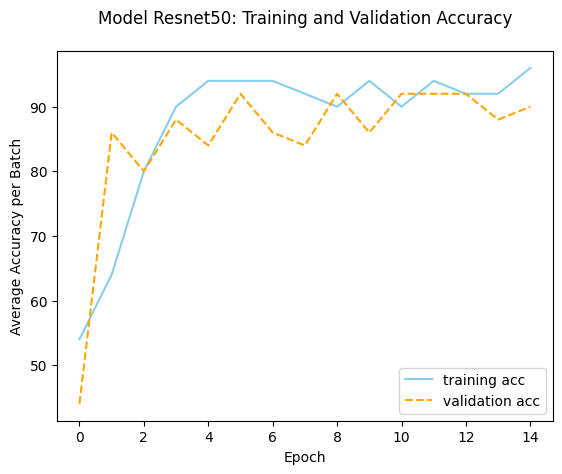

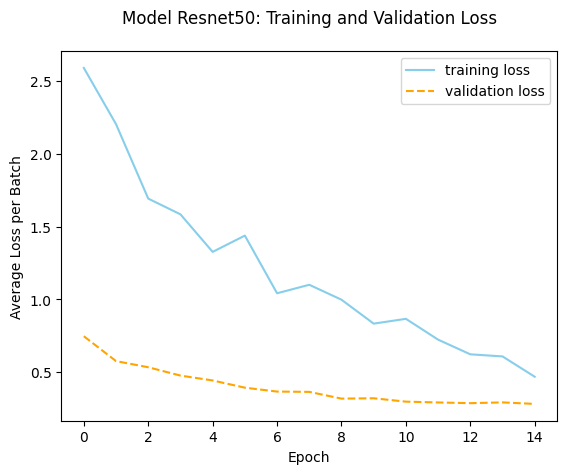

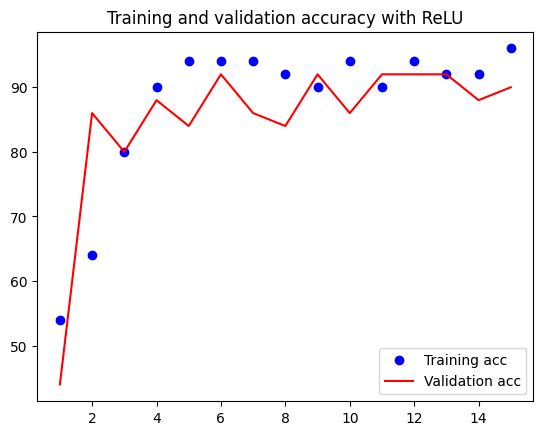

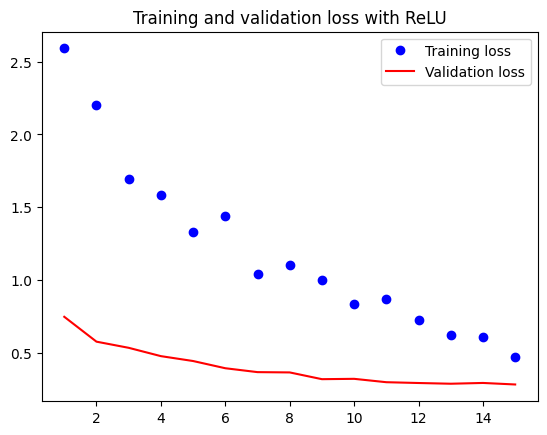

In [26]:

#                                Visualization

#-----------------------------------Plot 1---------------------------------
# Training Reseults: Resnet50
plt.figure()
resnet50_train_acc = history_resnet50['train_acc']
resnet50_val_acc = history_resnet50['val_acc']
resnet50_epoch = range(0, len(resnet50_train_acc), 1)
plot5, = plt.plot(resnet50_epoch, resnet50_train_acc, linestyle = "solid", color = "skyblue")
plot6, = plt.plot(resnet50_epoch, resnet50_val_acc, linestyle = "dashed", color = "orange")
plt.legend([plot5, plot6], ['training acc', 'validation acc'])
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy per Batch')
plt.title('Model Resnet50: Training and Validation Accuracy', pad = 20)
plt.savefig('Resnet50-Acc-Plot.png')

plt.figure()
resnet50_train_loss = history_resnet50['train_loss']
resnet50_val_loss = history_resnet50['val_loss']
resnet50_epoch = range(0, len(resnet50_train_loss), 1)
plot7, = plt.plot(resnet50_epoch, resnet50_train_loss, linestyle = "solid", color = "skyblue")
plot8, = plt.plot(resnet50_epoch, resnet50_val_loss, linestyle = "dashed", color = "orange")
plt.legend([plot7, plot8], ['training loss', 'validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Average Loss per Batch')
plt.title('Model Resnet50: Training and Validation Loss', pad = 20)
plt.savefig('Resnet50-Loss-Plot.png')

#-----------------------------------Plot 2---------------------------------
plt.figure()
acc =history_resnet50['train_acc']
val_acc = history_resnet50['val_acc']
loss = history_resnet50['train_loss'] 
val_loss = history_resnet50['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy with ReLU')
plt.legend()
plt.savefig('Training and validation accuracy with ReLU.png')

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss with ReLU')
plt.legend()
plt.savefig('Training and validation loss with ReLU.png')

plt.show()



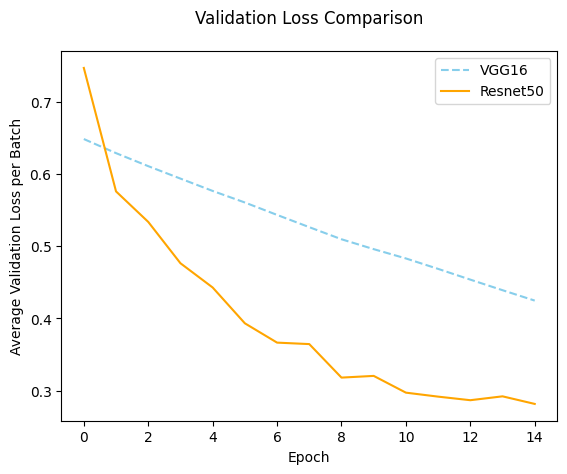

In [27]:
#-----------------------------------Plot 3---------------------------------

plt.figure()
df_valid_loss = pd.DataFrame({'Epoch': range(0, N_EPOCHS, 1),
                       'valid_loss_vgg': history_vgg['val_loss'],
                       'valid_loss_resnet50':history_resnet50['val_loss']
                       })
plota, = plt.plot('Epoch', 'valid_loss_vgg', data=df_valid_loss, linestyle = '--', color = 'skyblue')
plotb, = plt.plot('Epoch', 'valid_loss_resnet50', data=df_valid_loss, color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Average Validation Loss per Batch')
plt.title('Validation Loss Comparison', pad = 20)
plt.legend([plota, plotb], ['VGG16', 'Resnet50'])
plt.savefig('Result_Comparison.png')

#plot loss and accuracy for detection overfitting (15 epochs)
